In [6]:
# %%
from generate_mdps import generate_datsets
from dataset import MDPDataset, AllNodeFeatures, InMemoryMDPDataset, TransitionsOnEdge
from experiment import Experiment
from MDP_helpers import calculate_gap, multiclass_recall_score

# %%
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GCN, GAT
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import random_split
from collections import defaultdict
from sklearn.metrics import recall_score, accuracy_score
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler

from time import time
from tqdm import tqdm

torch.cuda.manual_seed(12345)
np.random.seed(12345)

import pickle

In [7]:
# Configs
experiment_name = "GAT_weighted_edge"
hparam_file = "hparams"
ascending = True
edge_attributes = True
gnn_model = GAT
pre_transform = TransitionsOnEdge()
lr = 0.001
N_epochs = 3000
N_datasets = 100

N_sites = 6
N_species = 20
K = 8
N_states = 3**N_sites

training_configs = {
    "Re-create data": False,
    "N_trials": 5
}

filename = f'Reserve_MDP_{N_states}_{K}'

In [8]:
# Create experiment folder
experiment_exists = os.path.isfile(f"Results/{experiment_name}/{hparam_file}")
if not experiment_exists:
    raise Exception("Hparams do not yet exist!")

# Get device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using Device: {device}")

experiment = Experiment(savefile=f"Results/{experiment_name}/{hparam_file}")

print("Top 10 Hparams (including previous runs)")
hparams = pd.DataFrame(experiment.load()).sort_values(by="score", ascending=ascending).head()
print(hparams)

best_params = hparams.iloc[0].to_dict()

Using Device: cuda
Top 10 Hparams (including previous runs)
       score  hidden_channels  num_layers   dropout  weight_decay
29  0.710123            249.0         3.0  0.049082      0.001125
28  0.737330            120.0         3.0  0.047526      0.001454
27  0.749871            161.0         3.0  0.042554      0.001014
26  0.767374            150.0         3.0  0.044162      0.001383
25  0.871606            150.0         3.0  0.045378      0.001202


In [9]:
best_params

{'score': 0.7101234793663025,
 'hidden_channels': 249.0,
 'num_layers': 3.0,
 'dropout': 0.04908228290945542,
 'weight_decay': 0.0011251859096131807}

In [10]:
folder_exists = os.path.isdir(f"Results/{experiment_name}/{filename}")
if folder_exists:
    raise Exception("Folder exists: Experiment Exists Already!")
else:
    print("Creating experiment folder: Results/", experiment_name, "/", filename)
    os.mkdir(f"Results/{experiment_name}/{filename}")

print(f"MDP Data: N_states: {N_states}")
dataset_folder = f"Reserve_MDP_{N_states}_{K}"
generate_datsets(N_sites, N_species, K, N_datasets, remove_previous=training_configs["Re-create data"], folder=dataset_folder)

print("Loading data into dataloader")
print(pre_transform)
dataset = InMemoryMDPDataset(f"datasets/{dataset_folder}", pre_transform=pre_transform)
print(dataset[0])
if torch.all(dataset[0].R == dataset[5].R):
    raise Exception("Datasets are likely identical!!")

Creating experiment folder: Results/ GAT_weighted_edge / Reserve_MDP_729_8
MDP Data: N_states: 729
Loading data into dataloader


/home/james/Repo/MDP-State-Abstraction-CSIRO/Approach_new/sensitive_states/dataset.py:125: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  edge_features = torch.Tensor([P[:, i[0], i[1]].numpy() for i in edges])


Data(x=[729, 6], edges=[2, 10176], edge_features=[10176, 6], k_labels=[729], P=[6, 729, 729], R=[729, 6], V=[729])


In [11]:
# indices = np.arange(N_datasets)
# train_ids = indices[:80]
# test_ids = indices[80:]

In [12]:
all_results = defaultdict(lambda : defaultdict(list))
print(f"Starting K-fold cross validation using device {device}")
kfold = KFold(n_splits=training_configs["N_trials"], shuffle=True)
for trial_num, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
# trial_num = 0
# trial_name = "trial"
    train_sampler = SubsetRandomSampler(train_ids)
    test_sampler = SubsetRandomSampler(test_ids)

    train_data = DataLoader(dataset, batch_size=1, sampler=train_sampler)
    test_data = DataLoader(dataset, batch_size=1, sampler=test_sampler)

    trial_name = f"trial_{trial_num}"

    hidden_channels = int(best_params['hidden_channels'])
    num_layers = int(best_params['num_layers'])
    dropout = best_params['dropout']
    weight_decay = best_params['weight_decay']

    model = gnn_model(
        in_channels=dataset[0].x.shape[1], 
        out_channels=K, 
        hidden_channels=hidden_channels, 
        num_layers=num_layers, 
        dropout=dropout
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    epochs = tqdm(range(N_epochs))
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()     

        loss = 0
        for data in train_data:
            if edge_attributes:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                    edge_attr=data.edge_features.to(device)
                )
            else:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                )  
            weight = torch.bincount(data.k_labels)
            weight = weight/weight.sum()
            loss += F.cross_entropy(pred, data.k_labels.to(device), weight=weight.to(device))

        loss /= len(train_data) 
        loss.backward()
        optimizer.step()

        all_results[trial_name]['training_loss'].append(loss.to('cpu').detach().float())


        model.eval()
        test_loss = 0
        avg_gap = 0
        avg_error = 0
        avg_recall = 0
        avg_acc = 0
        for data in test_data:
            if edge_attributes:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                    edge_attr=data.edge_features.to(device)
                )
            else:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                )  
            pred_k = F.softmax(pred, dim=1).argmax(axis=1)
            weight = torch.bincount(data.k_labels)
            weight = weight/weight.sum()
            test_loss += F.cross_entropy(pred, data.k_labels.to(device), weight=weight.to(device))
            gap, error = calculate_gap(data.P, data.R, data.V, pred_k, K, device='cpu')
            avg_gap += gap
            avg_error += error
            avg_recall += recall_score(data.k_labels, pred_k.to('cpu'), average="macro")
            avg_acc += accuracy_score(data.k_labels, pred_k.to('cpu'))


        test_loss /= len(test_data)
        avg_gap /= len(test_data)
        avg_error /= len(test_data)
        avg_recall /= len(test_data)
        avg_acc /= len(test_data)

        all_results[trial_name]['test_loss'].append(test_loss.to('cpu').detach().float())
        all_results[trial_name]['test_gap'].append(avg_gap)
        all_results[trial_name]['test_error'].append(avg_error)
        all_results[trial_name]['test_recall'].append(avg_recall)
        all_results[trial_name]['test_accuracy'].append(avg_acc)

        epochs.set_description(f"Trial {trial_num}, Epoch {epoch+1}/{N_epochs}, Loss {test_loss:.4f}, Gap {avg_gap:.4f}, Recall {avg_recall:.4f}, Accuracy {avg_acc:.4f}")

Starting K-fold cross validation using device cuda


  0%|          | 0/3000 [00:00<?, ?it/s]/home/james/Repo/MDP-State-Abstraction-CSIRO/Approach_new/sensitive_states/MDP_helpers.py:32: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  Q[:, a] = R[:, a].T + gamma*T[a, :, :]@V
Trial 0, Epoch 3000/3000, Loss 0.7218, Gap 0.2039, Recall 0.5842, Accuracy 0.7185: 100%|██████████| 3000/3000 [1:12:37<00:00,  1.45s/it]
Trial 1, Epoch 3000/3000, Loss 0.8395, Gap 0.2365, Recall 0.5287, Accuracy 0.6691: 100%|██████████| 3000/3000 [1:11:36<00:00,  1.43s/it]
Trial 2, Epoch 3000/3000, Loss 0.8519, Gap 0.2235, Recall 0.5195, Accuracy 0.6544: 100%|██████████| 3000/3000 [1:11:40<00:00,  1.43s/it]
Trial 3, Epoch 3000/3000, Loss 0.7828, Gap 0.2102,

In [13]:
print("Saving Model")
file = open(f"Results/{experiment_name}/{filename}/model.pckl", "wb")
pickle.dump(model, file)
file.close()

Saving Model


Saving Data to files
Generating plots


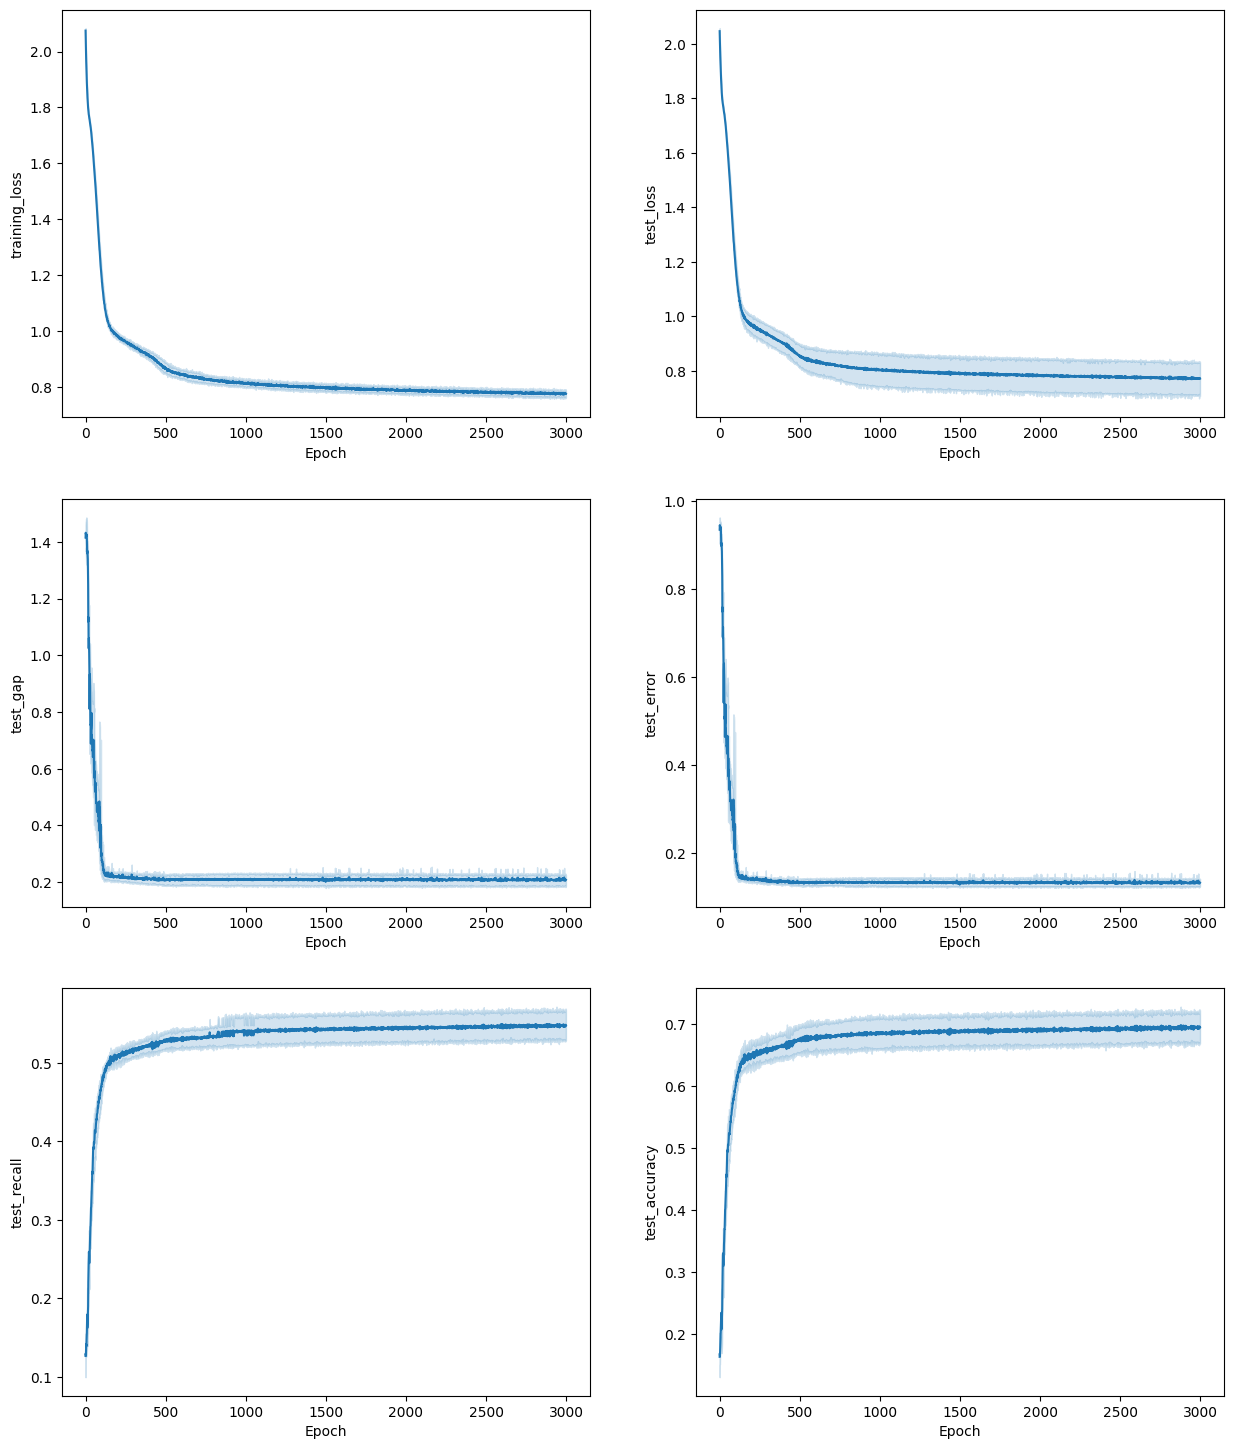

In [14]:
print("Saving Data to files")
processed = {}
for key in all_results["trial_0"].keys():
    df = pd.DataFrame({trial_id:all_results[trial_id][key] for trial_id in all_results.keys()}).astype(float)
    df.to_csv(f"Results/{experiment_name}/{filename}/{key}.csv")
    processed[key] = df
print("Generating plots")
n_plots = len(all_results["trial_0"].keys())
n_cols = 2
n_rows = int((n_plots + n_plots%2)/2)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 6*n_rows))

count = 0
for key in all_results["trial_0"].keys():
    col = count %2
    row = count //2 
    count += 1

    df_long = processed[key].stack()
    df_long.index = df_long.index.to_flat_index().map(lambda x: x[0])
    sns.lineplot(df_long, errorbar='ci', ax=ax[row, col])
    ax[row, col].set_ylabel(key)
    ax[row, col].set_xlabel("Epoch")

plt.savefig(f"Results/{experiment_name}/{filename}/plots.png")

In [15]:
!shutdown

Shutdown scheduled for Fri 2023-12-15 12:29:37 AEST, use 'shutdown -c' to cancel.
